Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Available columns in RRP details: ['operationDt', 'deliveryDt', 'maturityDt', 'operationType', 'auctionMethod', 'settlementType', 'termsCalenderDays', 'term', 'closeTm', 'totalAmtSubmitted', 'totalAmtAccepted', 'participatingCptyCount', 'acceptedCptyCount', 'propositions', 'results', 'amountOutstanding', 'memo', 'releaseTm', 'tsyOfferRate', 'mbsOfferRate']


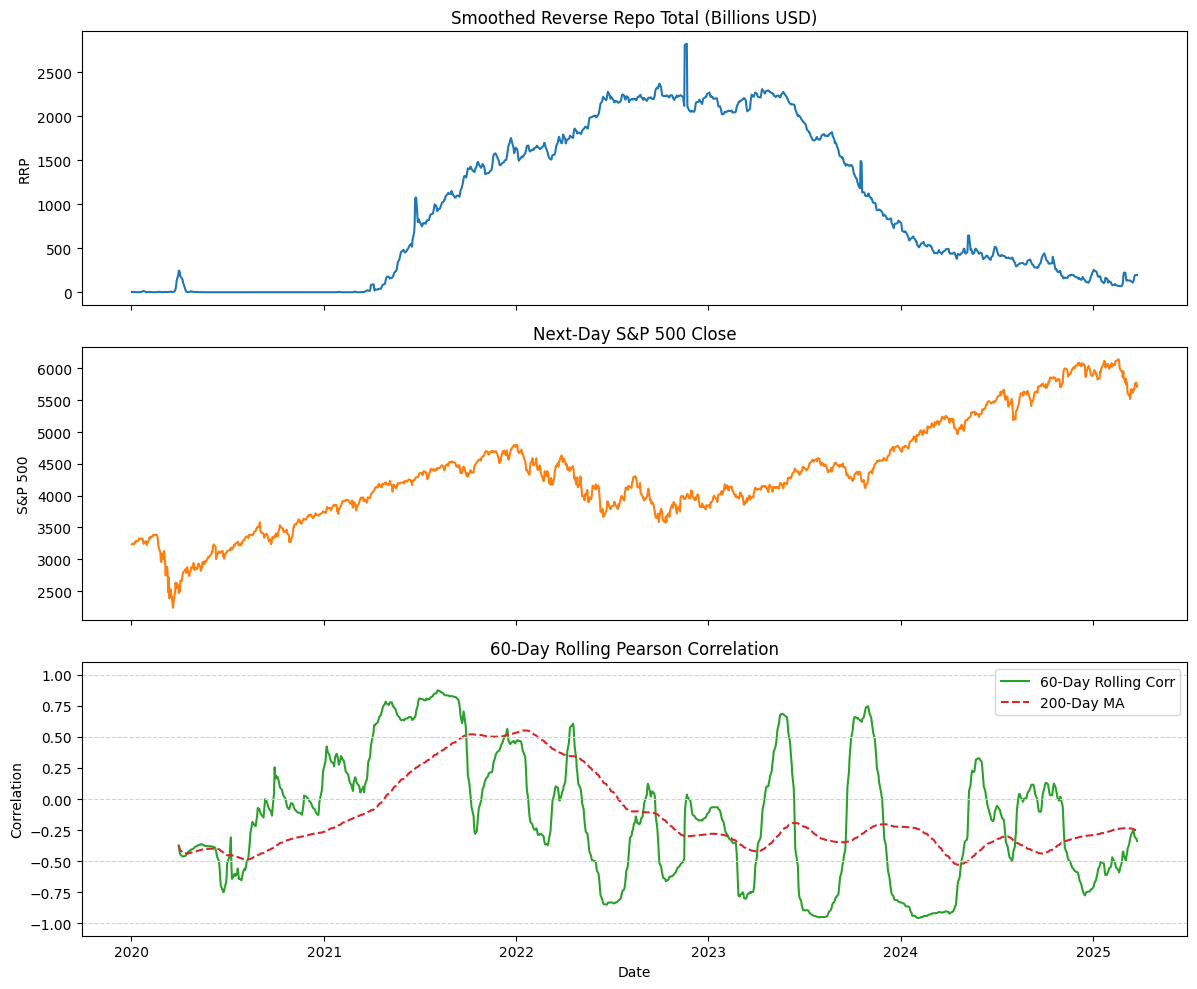

In [2]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install pandas_datareader
%pip install requests


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import pandas_datareader.data as web
import subprocess

# ---------------------------
# 1. Fetch and Parse Reverse Repo (RRP) Data
# ---------------------------
start_date = "2020-01-01"
end_date   = "2025-03-27"  # adjust as needed
domain = "markets.newyorkfed.org"
url = f"https://{domain}/read?productCode=70&startDt={start_date}&endDt={end_date}&operationTypes=Reverse%20Repo&eventCodes=730&sort=postDt:1"

response = requests.get(url)
response.raise_for_status()  # raise an error if the request fails
data_dict = response.json()

# Create a DataFrame from the 'data' list in the response
df_rrp = pd.json_normalize(data_dict['data'])
# The 'data' column contains a JSON string; parse it into a DataFrame:
df_details = df_rrp['data'].apply(json.loads)
df_details = pd.json_normalize(df_details)
print("Available columns in RRP details:", df_details.columns.tolist())

# Determine the correct date column: prefer 'operationDt', otherwise 'postDt'
if 'operationDt' in df_details.columns:
    date_col = 'operationDt'
elif 'postDt' in df_details.columns:
    date_col = 'postDt'
else:
    raise KeyError("Neither 'operationDt' nor 'postDt' found in the data columns.")

# Convert the date column to datetime, sort, and set as index
df_details[date_col] = pd.to_datetime(df_details[date_col])
df_details.sort_values(date_col, inplace=True)
df_details.set_index(date_col, inplace=True)

# Create a Series for the RRP total amount accepted and ensure numeric type
rrp_series = pd.to_numeric(df_details['totalAmtAccepted'], errors='coerce')

# ---------------------------
# 2. Remove Outliers using a 3-Day Rolling Median and MAD
# ---------------------------
window = 3
roll_med = rrp_series.rolling(window, min_periods=1).median()
roll_mad = rrp_series.rolling(window, min_periods=1).apply(
    lambda x: np.median(np.abs(x - np.median(x))), raw=True
)
threshold = 3.0
deviation = np.abs(rrp_series - roll_med)
outlier_mask = deviation > (threshold * roll_mad)
rrp_clean = rrp_series.copy()
rrp_clean[outlier_mask] = np.nan
rrp_clean_ff = rrp_clean.ffill()

# ---------------------------
# 3. Aggregate Duplicate Dates (if any)
# ---------------------------
if rrp_clean_ff.index.duplicated().any():
    rrp_clean_ff = rrp_clean_ff.groupby(rrp_clean_ff.index).sum()

# ---------------------------
# 4. Smooth the RRP Data using a 3-Day Simple Moving Average (SMA)
# ---------------------------
smoothing_window = 3
rrp_smoothed = rrp_clean_ff.rolling(window=smoothing_window, min_periods=1).mean()

# ---------------------------
# 5. Fetch S&P 500 Daily Closing Prices via FRED
# ---------------------------
start_date_spx = rrp_smoothed.index.min().strftime("%Y-%m-%d")
end_date_spx = (pd.Timestamp.today() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")
spx_data = web.DataReader("SP500", "fred", start_date_spx, end_date_spx)
if spx_data.empty:
    raise Exception("No data returned for SP500 from FRED.")
spx_close = spx_data["SP500"]
spx_close.sort_index(inplace=True)

# ---------------------------
# 6. Align RRP with Next-Day S&P 500 Close
# ---------------------------
spx_next = spx_close.shift(-1)
combined_df = pd.DataFrame({
    'RRP_total': rrp_smoothed,
    'SPX_next_close': spx_next
})
combined_df.dropna(inplace=True)

# ---------------------------
# 7. Compute Rolling Correlation (28-day) for Diagnostic Purposes
# ---------------------------
window_days = 60
rolling_corr = combined_df['RRP_total'].rolling(window_days).corr(combined_df['SPX_next_close'])
corr_ma = rolling_corr.rolling(window=200, min_periods=1).mean()

# Plot three diagnostic charts: RRP, S&P 500, and their rolling correlation
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(combined_df.index, combined_df['RRP_total'] / 1e9, color='C0')
axes[0].set_title('Smoothed Reverse Repo Total (Billions USD)')
axes[0].set_ylabel('RRP')

axes[1].plot(combined_df.index, combined_df['SPX_next_close'], color='C1')
axes[1].set_title('Next-Day S&P 500 Close')
axes[1].set_ylabel('S&P 500')

axes[2].plot(combined_df.index, rolling_corr, color='C2', label='60-Day Rolling Corr')
axes[2].plot(combined_df.index, corr_ma, color='C3', linestyle='--', label='200-Day MA')
for y in [-1, -0.5, 0, 0.5, 1]:
    axes[2].axhline(y, color='lightgray', linestyle='--', linewidth=0.8)
axes[2].set_title('60-Day Rolling Pearson Correlation')
axes[2].set_ylabel('Correlation')
axes[2].set_xlabel('Date')
axes[2].legend()

plt.tight_layout()
plt.show()